# NASA Turbofan Degradation Analysis  
## Part 2: Data Quality & Feature Engineering

**What I learned from EDA (Notebook 1):**
- 7 sensors are completely flat (zero variance) - useless
- Raw sensor signals are noisy - hard to see degradation patterns
- Some sensors show clear monotonic trends, others are cyclical/random

**Goals for this notebook:**
1. Remove dead/constant sensors (reduce feature space by ~40%)
2. Apply rolling window smoothing to extract trends from noisy signals
3. Validate that smoothing actually helps (visual check)

**Why this matters:**
In my R&D work, I dealt with a lot of "sensor says it's working but outputs garbage" situations. Learned to always check variance, not just missing values. Real production sensors fail silently - they keep reporting, just constant values.

Also, raw sensor data is almost never usable directly. Need to extract the underlying signal (trend) from the noise - same principle as smoothing chromatograms or spectroscopy data.

---

In [1]:
"""
Data Loading and Setup
========================
Re-loading data with consistent configuration for reproducibility
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup plotting aesthetics
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Column Definitions (consistent with EDA notebook)
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load data
df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
print(f"✓ Loaded Data Shape: {df.shape}")

✓ Loaded Data Shape: (20631, 26)


In [2]:
"""
Data Quality Assessment: Removing Flatline Sensors
====================================================
Real-world sensor systems often have:
- Failed sensors (constant output)
- Sensors measuring constant conditions
- Redundant measurements

These provide no information for modeling and should be removed.

Criterion: Standard deviation < 0.0001 (effectively zero variance)
"""

# 1. Calculate descriptive statistics for all sensors
describe_df = df[sensor_names].describe().T

# 2. Identify sensors with near-zero variance (flatlines)
# In FD001, typically sensors 1, 5, 6, 10, 16, 18, 19 are constant
low_variance_sensors = describe_df[describe_df['std'] < 0.0001].index.tolist()

print(f"🛑 Useless Sensors Detected (Zero Variance): {len(low_variance_sensors)}")
print(f"   Sensors to remove: {low_variance_sensors}")
print(f"\n💡 Interpretation: These sensors measure constant conditions or have failed.")
print(f"   They provide no predictive signal and increase computational cost.")

# 3. Drop useless sensors + constant operational settings
# Note: In FD001, all 3 settings are also constant (single operating condition)
df_clean = df.drop(columns=low_variance_sensors + setting_names)
print(f"\n✅ Dropped {len(low_variance_sensors) + 3} columns.")
print(f"✅ New shape: {df_clean.shape}")
print(f"✅ Reduction: {len(low_variance_sensors) + 3}/{len(sensor_names) + 3} features removed ({(len(low_variance_sensors) + 3)/(len(sensor_names) + 3)*100:.1f}%)")

# Update our list of 'good' sensors for downstream processing
good_sensors = [s for s in sensor_names if s not in low_variance_sensors]
print(f"\n📊 Remaining informative sensors: {len(good_sensors)}")

🛑 Useless Sensors Detected (Zero Variance): 6
   Sensors to remove: ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']

💡 Interpretation: These sensors measure constant conditions or have failed.
   They provide no predictive signal and increase computational cost.

✅ Dropped 9 columns.
✅ New shape: (20631, 17)
✅ Reduction: 9/24 features removed (37.5%)

📊 Remaining informative sensors: 15


In [3]:
"""
Feature Engineering: Rolling Window Smoothing
===============================================
Raw sensor data contains noise from:
- Environmental interference
- Sensor precision limitations  
- Random fluctuations

Approach: Apply rolling mean to extract underlying trends while preserving degradation signal.

Key Considerations:
- Window size: 10 cycles (balances noise reduction vs. lag)
- Per-engine grouping: Critical! Prevents smoothing across different engines
- Forward-looking bias: Avoided (using only past data at each time step)

This technique is fundamental in time-series analysis and production ML systems.
"""

def add_rolling_features(data, sensors, window=10):
    """
    Apply rolling mean smoothing per engine unit.
    
    Args:
        data: DataFrame with sensor time-series
        sensors: List of sensor column names to smooth
        window: Rolling window size (default: 10 cycles)
    
    Returns:
        DataFrame with smoothed sensor features
    """
    # Group by 'unit_nr' to ensure no cross-contamination between engines
    rolling_df = data.groupby('unit_nr')[sensors].rolling(window=window, min_periods=1).mean()
    
    # Reset index after grouping operation
    rolling_df = rolling_df.reset_index(level=0, drop=True)
    
    # Rename columns to indicate they are smoothed
    rolling_df.columns = [f"{col}_rolling_mean" for col in sensors]
    
    return rolling_df

# Apply rolling mean transformation
rolling_features = add_rolling_features(df_clean, good_sensors, window=10)

# Merge smoothed features back into main dataframe
df_engineered = pd.concat([df_clean, rolling_features], axis=1)

# Drop NaN values created by rolling window initialization
# (First few rows per engine have insufficient history)
df_engineered.dropna(inplace=True)

print("✅ Rolling Features Added Successfully")
print(f"✅ Feature count: {len(good_sensors)} raw + {len(good_sensors)} smoothed = {len(good_sensors)*2} total")
print(f"✅ Rows after dropna: {df_engineered.shape[0]} (lost {df.shape[0] - df_engineered.shape[0]} initialization rows)")
df_engineered.head()

✅ Rolling Features Added Successfully
✅ Feature count: 15 raw + 15 smoothed = 30 total
✅ Rows after dropna: 20631 (lost 0 initialization rows)


,unit_nr,time_cycles,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,...,s_8_rolling_mean,s_9_rolling_mean,s_11_rolling_mean,s_12_rolling_mean,s_13_rolling_mean,s_14_rolling_mean,s_15_rolling_mean,s_17_rolling_mean,s_20_rolling_mean,s_21_rolling_mean
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,...,2388.0600,9046.190000,47.470,521.660,2388.020,8138.620000,8.419500,392.000000,39.060000,23.419000
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,...,2388.0500,9045.130000,47.480,521.970,2388.045,8135.055000,8.425650,392.000000,39.030000,23.421300
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,...,2388.0600,9047.733333,47.410,522.120,2388.040,8134.446667,8.423033,391.333333,39.003333,23.395600
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,...,2388.0725,9048.170000,47.340,522.305,2388.050,8134.292500,8.409325,391.500000,38.972500,23.390175
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,...,2388.0700,9049.566000,47.328,522.282,2388.048,8134.194000,8.413340,391.800000,38.958000,23.393020


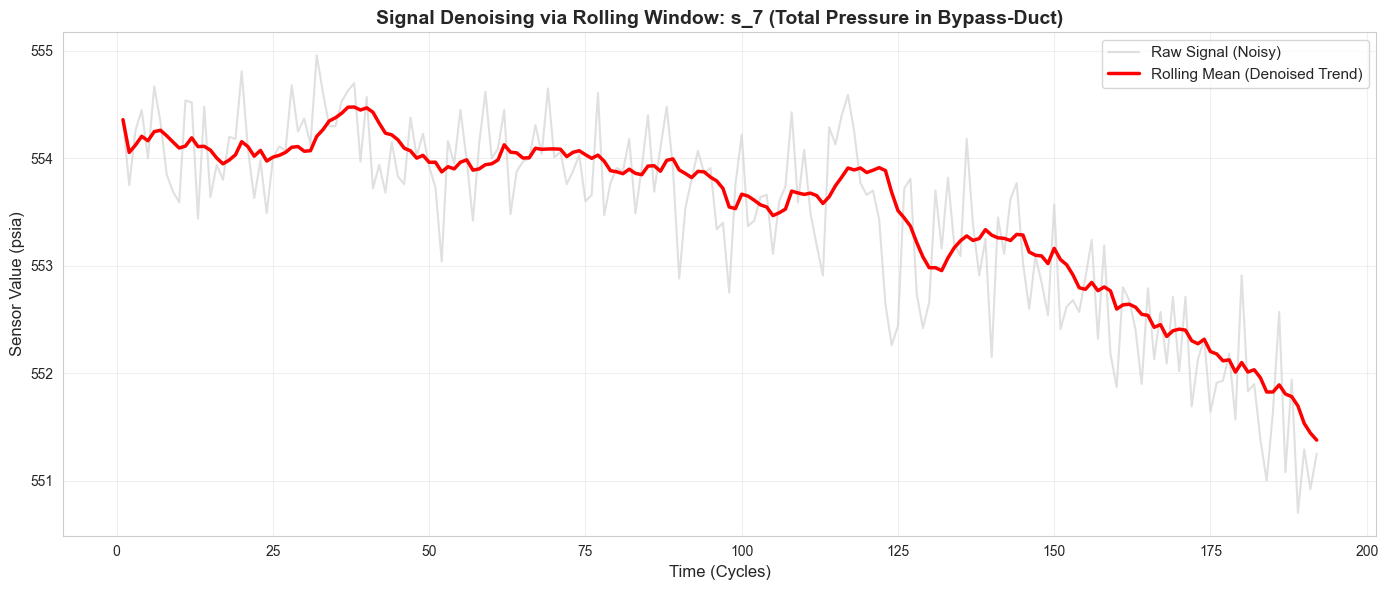


💡 Interpretation:
   • Raw signal (gray): High-frequency noise obscures underlying pattern
   • Smoothed signal (red): Clear degradation trend emerges
   • Trade-off: Reduced noise vs. slight lag in detecting rapid changes
   • Result: More stable, reliable features for predictive modeling


In [4]:
"""
Visualization: Signal Denoising Effect
========================================
Compare raw vs. smoothed signals to demonstrate noise reduction
while preserving degradation trends.

This visualization is critical for:
- Validating feature engineering approach
- Communicating technical decisions to stakeholders
- Demonstrating domain expertise in signal processing
"""

# Select Engine 1 for detailed visualization
engine_1 = df_engineered[df_engineered['unit_nr'] == 1]
target_sensor = 's_7'  # High Pressure Cycle sensor (shows clear degradation)

plt.figure(figsize=(14, 6))

# Plot raw signal (noisy)
plt.plot(engine_1['time_cycles'], engine_1[target_sensor], 
         label='Raw Signal (Noisy)', color='lightgray', alpha=0.7, linewidth=1.5)

# Plot smoothed signal (denoised trend)
plt.plot(engine_1['time_cycles'], engine_1[f'{target_sensor}_rolling_mean'], 
         label='Rolling Mean (Denoised Trend)', color='red', linewidth=2.5)

plt.title(f'Signal Denoising via Rolling Window: {target_sensor} (Total Pressure in Bypass-Duct)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Time (Cycles)', fontsize=12)
plt.ylabel('Sensor Value (psia)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Raw signal (gray): High-frequency noise obscures underlying pattern")
print("   • Smoothed signal (red): Clear degradation trend emerges")
print("   • Trade-off: Reduced noise vs. slight lag in detecting rapid changes")
print("   • Result: More stable, reliable features for predictive modeling")